In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import  warnings
warnings.filterwarnings("ignore")

In [91]:
feature=pd.read_csv('data/temps.csv')
feature.head()
#temp2 前天的最高温度，temp1昨天的坐高温度，average 历史每年这一天的平均温度，actual 当天真实最高温度(label)，friend，朋友推测的可能值

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [92]:
feature.shape

(348, 9)

In [93]:
#处理时间数据
import datetime
years=feature['year']
months=feature['month']
days=feature['day']
#datetime格式
dates=[str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]

In [94]:
#转换为datetime
dates=[datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

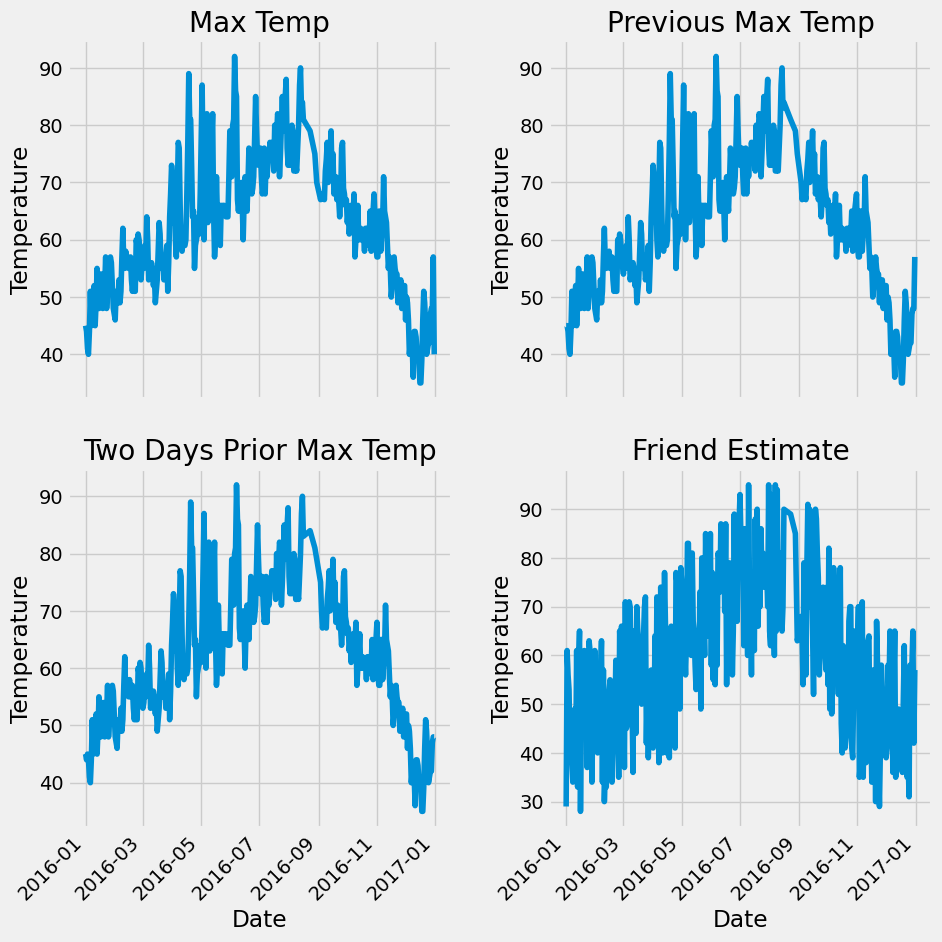

In [95]:
# 准备画图
# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, feature['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, feature['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, feature['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, feature['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)
plt.show()

In [96]:
#独热编码
feature=pd.get_dummies(feature)
feature.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [97]:
labels=feature['actual']
features=feature.drop(['actual'],axis=1)
feature_names=list(features.columns)
features=np.array(features)
labels=np.array(labels)

In [98]:
features.shape

(348, 14)

In [99]:
from sklearn import preprocessing
input_features=preprocessing.StandardScaler().fit_transform(features)

In [100]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

In [101]:
#构建神经网络模型
x=torch.tensor(input_features,dtype=float)
y=torch.tensor(labels,dtype=float)

#权重参数初始化
learning_rate=0.001

weights=torch.randn((14,128),dtype=float,requires_grad=True)
biases=torch.randn(128,dtype=float,requires_grad=True)
weights2=torch.randn((128,1),dtype=float,requires_grad=True)
biases2=torch.randn(1,dtype=float,requires_grad=True)

losses=[]
for i in range(1000):
    # 计算隐藏层
    hidden=x.mm(weights)+biases
    #加入激活函数
    hidden=torch.relu(hidden)
    #预测结果 wx+b
    predictions=hidden.mm(weights2)+biases2
    #计算损失
    loss=torch.mean((predictions-y)**2)
    losses.append(loss.data.numpy())

    #打印损失
    if i%100==0:
        print('loss',loss)
    #反向传播
    loss.backward()
    #手动更新参数 梯度*学习率 反方向 注意 add 是返回一个新的张量，add_是在原来的基础上操作的
    weights.data.add_(-learning_rate*weights.grad.data)
    biases.data.add_(-learning_rate*biases.grad.data)
    weights2.data.add_(-learning_rate*weights2.grad.data)
    biases2.data.add_(-learning_rate*biases2.grad.data)
    #迭代完成梯度清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss tensor(4046.6768, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(157.4678, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(147.6956, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(144.7513, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(143.2766, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(142.3702, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.7395, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(141.2849, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(140.9435, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss tensor(140.6849, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [102]:
predictions.shape

torch.Size([348, 1])

In [103]:
# 使用框架构建网络模型
input_size=input_features.shape[1]
hidden_size=128
output_size=1
batch_size=16
my_nn=torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size)
)
#平均损失
cost=torch.nn.MSELoss(reduction='mean')
#优化器更新参数
optim=torch.optim.Adam(my_nn.parameters(),lr=0.01)


In [104]:
losses=[]
for i in range(1000):
    batch_loss=[]
    for start in range(0,len(input_features),batch_size):
        end=start+batch_size if start+batch_size<len(input_features) else len(input_features)
        xx=torch.tensor(input_features[start:end],dtype=torch.float,requires_grad=True)
        yy=torch.tensor(labels[start:end],dtype=torch.float,requires_grad=True)
        predictions=my_nn(xx)
        loss=cost(predictions,yy)
        optim.zero_grad()
        loss.backward(retain_graph=True)
        optim.step()
        batch_loss.append(loss.data.numpy())

    if i %100==0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))


0 3211.1648
100 35.08158
200 38.146366
300 39.32979
400 35.43481
500 35.291306
600 32.501163
700 34.04398
800 33.702152
900 32.743774


In [105]:
#预测训练结果
x=torch.tensor(input_features,dtype=torch.float)
predict=my_nn(x).data.numpy()
predict

array([[49.692932],
       [49.741272],
       [49.94388 ],
       [49.898506],
       [49.6633  ],
       [50.131744],
       [50.347534],
       [50.705204],
       [50.41262 ],
       [50.477303],
       [50.778145],
       [50.10547 ],
       [50.265327],
       [50.760056],
       [49.777016],
       [50.085102],
       [54.787567],
       [54.32041 ],
       [54.67021 ],
       [54.159195],
       [53.722076],
       [53.64715 ],
       [54.86263 ],
       [54.78042 ],
       [54.736084],
       [54.623306],
       [54.89778 ],
       [54.452892],
       [54.958214],
       [54.904007],
       [54.04615 ],
       [53.62025 ],
       [56.325974],
       [56.074966],
       [55.851982],
       [55.704773],
       [55.87977 ],
       [55.75343 ],
       [55.962196],
       [56.630424],
       [56.62564 ],
       [56.545197],
       [56.153267],
       [56.25908 ],
       [56.22757 ],
       [56.655125],
       [56.41211 ],
       [57.053955],
       [59.015095],
       [59.743095],


In [106]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_names.index('month')]
days = features[:, feature_names.index('day')]
years = features[:, feature_names.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)})

In [107]:
true_data.head()

,date,actual
0,2016-01-01,45
1,2016-01-02,44
2,2016-01-03,41
3,2016-01-04,40
4,2016-01-05,44


In [108]:
predictions_data.head()

,date,prediction
0,2016-01-01,49.692932
1,2016-01-02,49.741272
2,2016-01-03,49.943878
3,2016-01-04,49.898506
4,2016-01-05,49.663300


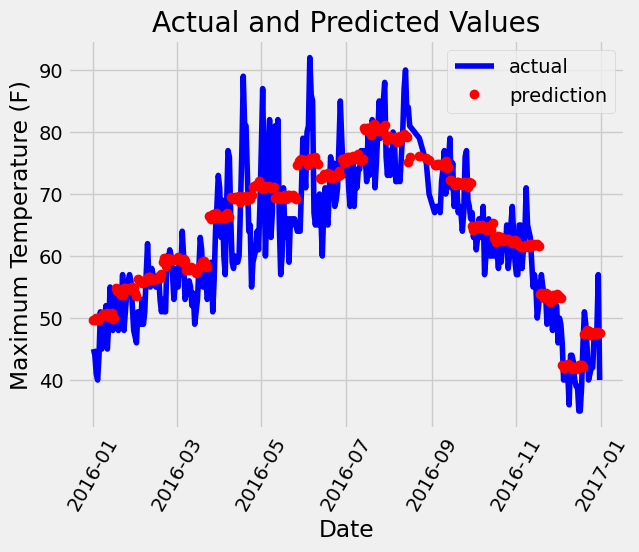

In [111]:
plt.plot(true_data['date'],true_data['actual'],'b-',label='actual')
plt.plot(predictions_data['date'],predictions_data['prediction'],'ro',label='prediction')
plt.xticks(rotation=60)
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');
plt.legend()
plt.show()
